In [1]:
# Corrección de cuantiles empírica.

import os
import sys

import pandas as pd
import numpy  as np

import xarray as xr

In [2]:
# Rutas de archivos.

names = [ "NSRDB", "NSRDB_2" ]
lat   = 19.41
lon   = -99.14

#df_d = xr.open_dataset(f"results/{names[0]}.nc").sel(
#    {"lat": lat, "lon": lon} ).to_dataframe().reset_index(
#    ).drop( ["lat", "lon"], axis = 1 ).set_index("time")

path_res = "../results/"
path_d = [ f"{path_res}{names[0]}.nc",
    f"{path_res}{names[1]}.nc" ]
path_r = f"{path_res}{names[1]}_{lat}_{lon}_quantile.nc"

df_d = xr.open_dataset( f"{path_d[0]}" ).sel(
    {"lat": lat, "lon": lon} ).to_dataframe(
    ).reset_index().drop( ["lon", "lat"], axis = 1 ).set_index("time")
df_r = xr.open_dataset( f"{path_d[1]}" ).sel(
    {"lat": lat, "lon": lon} ).to_dataframe(
    ).reset_index().drop( ["lon", "lat"], axis = 1 ).set_index("time")

In [3]:
print(df_d["DNI"].describe())
print(df_d["DNI"].resample("M").sum().mean())

count    219144.000000
mean        245.634943
std         353.143324
min           0.000000
25%           0.000000
50%           0.000000
75%         486.000000
max        1129.000000
Name: DNI, dtype: float64
179431.41333333333


In [4]:
print(df_r["DNI"].describe())
print(df_r["DNI"].resample("M").sum().mean())

count    149016.000000
mean        223.000980
std         347.410437
min           0.000000
25%           0.000000
50%           0.000000
75%         405.752500
max        1071.220000
Name: DNI, dtype: float64
162895.65681372548


In [6]:
print(df_q["DNI"].describe())
print(df_q["DNI"].resample("M").sum().mean())

count    149016.000000
mean        226.836976
std         345.588256
min           0.000000
25%           0.000000
50%           0.000000
75%         415.000000
max        1129.000000
Name: DNI, dtype: float64
165697.7394117647


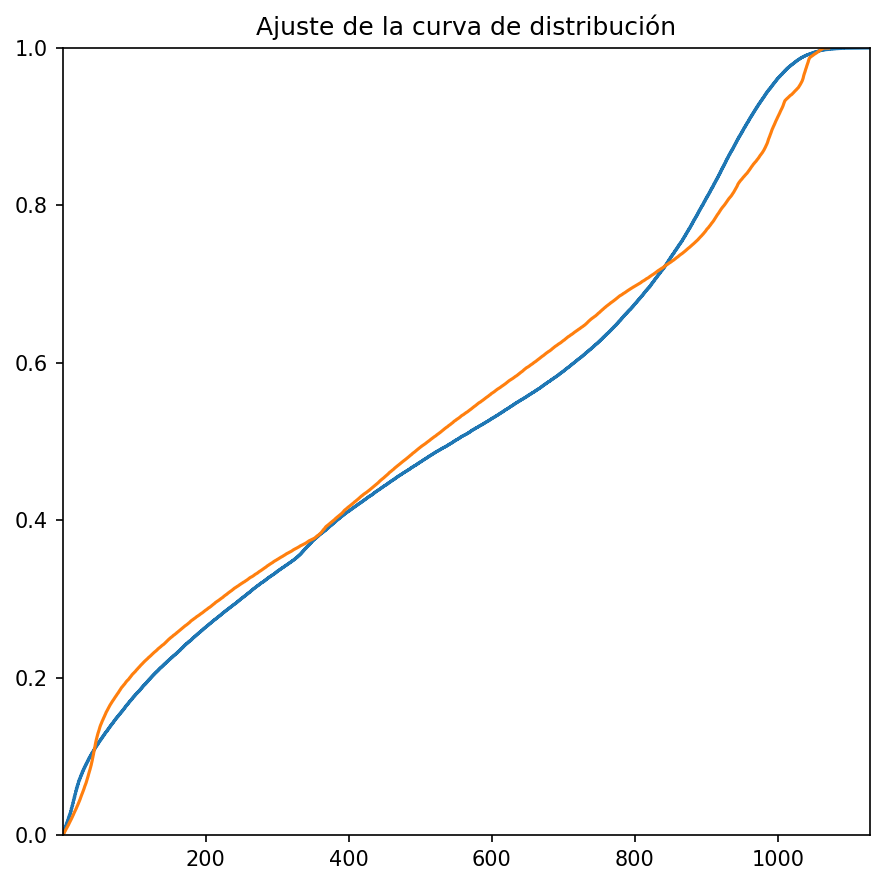

In [162]:
import matplotlib.pyplot as plt

# Graficamos
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

n_1 = df_d["DNI"].where(df_d["DNI"] >0, np.nan).dropna().sort_values()
ax.plot( n_1, np.linspace( 1 / n_1.shape[0] , 1, n_1.shape[0]) )

n_2 = df_r["DNI"].where(df_r["DNI"] >0, np.nan).dropna().sort_values()
ax.plot( n_2, np.linspace( 1 / n_2.shape[0] , 1, n_2.shape[0]) )

n_3 = df_q["DNI"].where(df_q["DNI"] >0, np.nan).dropna().sort_values()
#ax.plot( n_3, np.linspace( 1 / n_3.shape[0] , 1, n_3.shape[0]) )

ax.set_title("Ajuste de la curva de distribución")
ax.set_xlim( min(n_1.min(), n_2.min(), n_3.min()), max(n_1.max(), n_2.max(), n_3.max()) )
ax.set_ylim(0, 1)
#ax.legend( ["Datos", dist_n[d]] )
fig.tight_layout()
plt.show()

In [5]:
# Creamos un DataFrame de apoyo.
df_q = df_r.copy()
# Iteramos para todas las columnas.
for v in df_d.columns:
    # Ordenamos los valores originales y destino incluyendo el tiempo.
    if v in ["DNI", "GHI"]:
        df_i = df_d[[v]].where( df_d[[v]] > 0, np.nan
            ).dropna().sort_values(v).reset_index()
        df_j = df_r[[v]].where( df_r[[v]] > 0, np.nan
            ).dropna().sort_values(v).reset_index()
    else:
        df_i = df_d[[v]].sort_values(v).reset_index()
        df_j = df_r[[v]].sort_values(v).reset_index()
    # Calculamos la distribución acumulada.
    df_i["CDF"] = np.linspace( 1 / df_i.shape[0] , 1, df_i.shape[0] )
    df_j["CDF"] = np.linspace( 1 / df_j.shape[0] , 1, df_j.shape[0] )

    # Interpolamos los valores de la distribución origen a la destino.
    df_j["Cuant"] = np.interp( df_j["CDF"], df_i["CDF"],
        df_i[v] ).round( decimals = 2 )
    # Reordenamos los valores.
    df_q[v] = df_j.sort_values("time").set_index( "time" ).drop( [v, "CDF"],
        axis = 1 ).rename( {"Cuant": v}, axis = 1 )
    
df_q["DNI"] = df_q["DNI"].where( df_q["DNI"] > 0, 0 )
df_q["GHI"] = df_q["GHI"].where( df_q["GHI"] > 0, 0 )

df_q

,Temperature,GHI,Relative Humidity,Pressure,Wind Speed,Wind Direction,DNI
time,,,,,,,
2006-01-01 00:00:00,11.7,0.0,68.7,785.0,0.7,196.0,0.0
2006-01-01 01:00:00,11.0,0.0,69.8,784.0,0.8,208.0,0.0
2006-01-01 02:00:00,10.8,0.0,69.2,784.0,0.8,221.0,0.0
2006-01-01 03:00:00,10.4,0.0,68.4,784.0,0.6,232.0,0.0
2006-01-01 04:00:00,10.0,0.0,68.0,784.0,0.6,248.0,0.0
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,12.4,0.0,54.6,785.0,0.9,250.0,0.0
2022-12-31 20:00:00,11.5,0.0,59.4,786.0,1.1,255.0,0.0
2022-12-31 21:00:00,11.3,0.0,60.6,786.0,0.8,261.0,0.0


In [89]:
# Creamos un DataFrame de apoyo.
df_q = df_r.copy()
# Iteramos para todas las columnas.
for v in df_d.columns:
    # Ordenamos los valores originales y destino incluyendo el tiempo.
    df_i = df_d[[v]].sort_values(v).reset_index()
    df_j = df_r[[v]].sort_values(v).reset_index()
    # Calculamos la distribución acumulada.
    df_i["CDF"] = np.linspace( 1 / df_i.shape[0] , 1, df_i.shape[0] )
    df_j["CDF"] = np.linspace( 1 / df_j.shape[0] , 1, df_j.shape[0] )

    # Interpolamos los valores de la distribución origen a la destino.
    df_j["Cuant"] = np.interp( df_j["CDF"], df_i["CDF"],
        df_i[v] ).round( decimals = 2 )
    # Reordenamos los valores.
    df_q[v] = df_j.sort_values("time").set_index( "time" ).drop( [v, "CDF"],
        axis = 1 ).rename( {"Cuant": v}, axis = 1 )

df_q.head(24)

,Temperature,GHI,Relative Humidity,Pressure,Wind Speed,Wind Direction,DNI
time,,,,,,,
2006-01-01 00:00:00,11.7,0.00,68.7,785.0,0.7,196.0,0.0
2006-01-01 01:00:00,11.0,0.00,69.8,784.0,0.8,208.0,17.0
2006-01-01 02:00:00,10.8,0.00,69.2,784.0,0.8,221.0,17.0
2006-01-01 03:00:00,10.4,0.00,68.4,784.0,0.6,232.0,17.0
2006-01-01 04:00:00,10.0,0.00,68.0,784.0,0.6,248.0,17.0
2006-01-01 05:00:00,9.7,0.00,67.2,785.0,0.6,264.0,17.0
2006-01-01 06:00:00,9.8,0.00,64.9,785.0,0.4,280.0,17.0
2006-01-01 07:00:00,11.7,28.00,56.1,786.0,0.6,275.0,17.0
2006-01-01 08:00:00,15.7,254.00,43.9,786.0,0.8,259.0,17.0


In [147]:
v = "DNI"
df_i = df_d[[v]].where( df_d[[v]] > 0, np.nan
    ).dropna().sort_values(v).reset_index()
# Calculamos la distribución acumulada.
df_i["CDF"] = np.linspace( 1 / df_i.shape[0] , 1, df_i.shape[0] )

# Ordenamos los valores destino incluyendo el tiempo.
df_j = df_r[[v]].where( df_r[[v]] > 0, np.nan
    ).dropna().sort_values(v).reset_index()
# Calculamos la distribución acumulada.
df_j["CDF"] = np.linspace( 1 / df_j.shape[0] , 1, df_j.shape[0] )

# Interpolamos los valores de la distribución origen a la destino.
df_j["Cuant"] = np.interp( df_j["CDF"], df_i["CDF"],
    df_i[v] ).round( decimals = 1 )
# Reordenamos los valores.
df_q[v] = df_j.sort_values("time").set_index( "time" ).drop( [v, "CDF"],
    axis = 1 ).rename( {"Cuant": v}, axis = 1 )

df_q[v] = df_q[v].where( df_q[v] > 0, 0 )

df_q.head(24)

,Temperature,GHI,Relative Humidity,Pressure,Wind Speed,Wind Direction,DNI
time,,,,,,,
2006-01-01 00:00:00,11.8,0.0,68.8,785.0,0.7,198.0,0.0
2006-01-01 01:00:00,11.2,0.0,69.9,784.0,0.8,210.0,0.0
2006-01-01 02:00:00,10.9,0.0,69.3,784.0,0.7,222.0,0.0
2006-01-01 03:00:00,10.6,0.0,68.5,784.0,0.6,234.0,0.0
2006-01-01 04:00:00,10.2,0.0,68.1,784.0,0.5,250.0,0.0
2006-01-01 05:00:00,9.9,0.0,67.3,785.0,0.5,266.0,0.0
2006-01-01 06:00:00,9.9,0.0,65.0,785.0,0.4,282.0,0.0
2006-01-01 07:00:00,11.8,28.0,56.3,786.0,0.5,277.0,0.0
2006-01-01 08:00:00,15.7,250.0,44.3,786.0,0.8,261.0,611.4


In [54]:
# Creamos un DataFrame de apoyo.
v = "DNI"
df_q = df_r.copy()
df_q[v] = 0
for m in range(1, 13):
    df_i = df_d.loc[df_d.index.month == m, [v]].where( df_d[[v]] > 0, np.nan
        ).dropna().sort_values(v).reset_index()
    # Calculamos la distribución acumulada.
    df_i["CDF"] = np.linspace( 1 / df_i.shape[0] , 1, df_i.shape[0] )

    # Ordenamos los valores destino incluyendo el tiempo.
    df_j = df_r.loc[df_r.index.month == m, [v]].where( df_r[[v]] > 0, np.nan
        ).dropna().sort_values(v).reset_index()
    # Calculamos la distribución acumulada.
    df_j["CDF"] = np.linspace( 1 / df_j.shape[0] , 1, df_j.shape[0] )

    # Interpolamos los valores de la distribución origen a la destino.
    df_j["Cuant"] = np.interp( df_j["CDF"], df_i["CDF"],
        df_i[v] ).round( decimals = 1 )
    # Reordenamos los valores.
    df_k = df_j.sort_values("time").set_index( "time" ).drop( [v, "CDF"],
        axis = 1 ).rename( {"Cuant": v}, axis = 1 )
    df_q.loc[df_k.index, v] = df_k[v]

#df_q[v] = df_q[v].where( df_q[v] > 0, 0 )

df_q.head(24)

,Temperature,GHI,DNI,Relative Humidity,Pressure,Wind Speed,Wind Direction
time,,,,,,,
2006-01-01 00:00:00,11.8,0.0,0.0,68.8,785.0,0.7,198.0
2006-01-01 01:00:00,11.2,0.0,0.0,69.9,784.0,0.8,210.0
2006-01-01 02:00:00,10.9,0.0,0.0,69.3,784.0,0.7,222.0
2006-01-01 03:00:00,10.6,0.0,0.0,68.5,784.0,0.6,234.0
2006-01-01 04:00:00,10.2,0.0,0.0,68.1,784.0,0.5,250.0
2006-01-01 05:00:00,9.9,0.0,0.0,67.3,785.0,0.5,266.0
2006-01-01 06:00:00,9.9,0.0,0.0,65.0,785.0,0.4,282.0
2006-01-01 07:00:00,11.8,28.0,106.0,56.3,786.0,0.5,277.0
2006-01-01 08:00:00,15.7,250.0,709.0,44.3,786.0,0.8,261.0
